In [ ]:
!pip install tensorflow-io

In [ ]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

In [ ]:
!unzip /content/z-by-hp-unlocked-challenge-3-signal-processing.zip

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [77]:
! cp /content/audio_classifier.h5 /content/drive/MyDrive/1

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [35]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [7]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [8]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [9]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

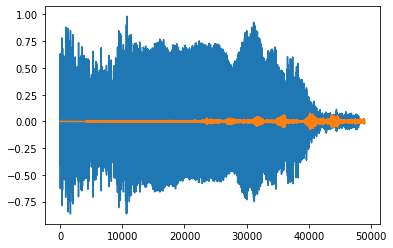

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [10]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [11]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [12]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [13]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [14]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [16]:
spectrogram, label = preprocess(filepath, label)

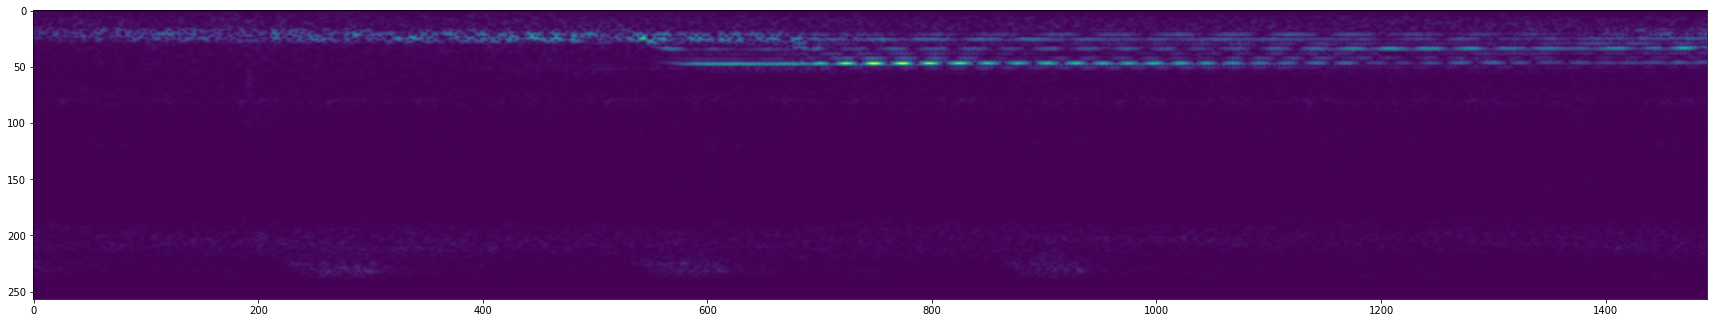

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [18]:
train = data.take(36)
test = data.skip(36).take(15)

In [19]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [29]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

In [32]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 15s 117ms/step - loss: 0.5881 - recall_2: 0.8766 - precision_2: 0.8544 - val_loss: 0.0649 - val_recall_2: 0.9692 - val_precision_2: 1.0000
Epoch 2/4
36/36 [==============================] - 3s 85ms/step - loss: 0.0279 - recall_2: 0.9875 - precision_2: 0.9937 - val_loss: 0.0070 - val_recall_2: 0.9848 - val_precision_2: 1.0000
Epoch 3/4
36/36 [==============================] - 3s 84ms/step - loss: 0.0081 - recall_2: 0.9939 - precision_2: 0.9939 - val_loss: 0.0260 - val_recall_2: 0.9630 - val_precision_2: 1.0000
Epoch 4/4
36/36 [==============================] - 3s 83ms/step - loss: 0.0078 - recall_2: 0.9873 - precision_2: 1.0000 - val_loss: 0.0027 - val_recall_2: 1.0000 - val_precision_2: 1.0000


In [33]:
from tensorflow.keras.models import load_model

In [34]:
model.save('audio_classifier.h5')

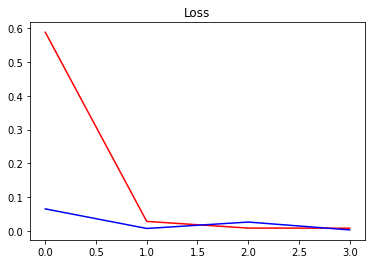

In [36]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [40]:
hist.history

{'loss': [0.5880830883979797,
  0.027893824502825737,
  0.008115356788039207,
  0.007801996544003487],
 'recall_2': [0.8766233921051025,
  0.987500011920929,
  0.9939393997192383,
  0.9873417615890503],
 'precision_2': [0.8544303774833679,
  0.9937106966972351,
  0.9939393997192383,
  1.0],
 'val_loss': [0.06494289636611938,
  0.006988086737692356,
  0.025968754664063454,
  0.002683679573237896],
 'val_recall_2': [0.9692307710647583,
  0.9848484992980957,
  0.9629629850387573,
  1.0],
 'val_precision_2': [1.0, 1.0, 1.0, 1.0]}

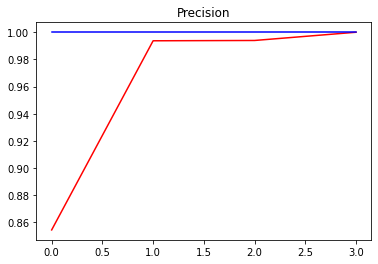

In [42]:
plt.title('Precision')
plt.plot(hist.history['precision_2'], 'r')
plt.plot(hist.history['val_precision_2'], 'b')
plt.show()

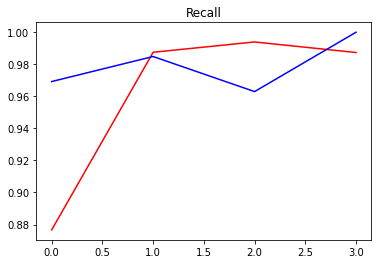

In [43]:
plt.title('Recall')
plt.plot(hist.history['recall_2'], 'r')
plt.plot(hist.history['val_recall_2'], 'b')
plt.show()

In [44]:
X_test, y_test = test.as_numpy_iterator().next()

In [45]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 114ms/step


In [46]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [47]:
yhat

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [49]:
y_test

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [50]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [51]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [52]:
wav = load_mp3_16k_mono(mp3)

In [53]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [54]:
samples, index = audio_slices.as_numpy_iterator().next()

In [55]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [66]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [67]:
yhat = model.predict(audio_slices)


1/1 [==============================] - 2s 2s/step


In [ ]:
yhat = [1 if prediction > 0.8 else 0 for prediction in yhat]
yhat

In [59]:
from itertools import groupby

In [69]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [70]:
calls

9

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [75]:
import csv

In [76]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])